In [1]:
%load_ext autoreload
%autoreload 2

# Running a Schwarzschild model

In this notebook you will learn how to run a Schwarzschild model using DYNAMITE, and then how to access and interact with the output of a model once it has been run. I will also highlight the motivation for one of our upcoming code developments: using better descriptions of the LOSVD.

I will introducuce necessary concepts as we go along (such as the model configuration file, and the specification of model parameters) but our focus will be on running a model and getting a feel for the output. More detailed descriptions of the lower-level concepts can be found in other tutorials.

## Setup

Let's import DYNMAITE. For the time being, to do the import, we have to modify out path as follows,

In [2]:
import sys
sys.path.insert(0,'../../')
import dynamite as dyn

Once we install DYNAMITE as a Python package, this will be unncessary, and you can import DYNAMITE in any location without modifying your path.

Next, let's read the model configuration, which - for this tutorial - is in the file
```
NGC6278_config.yaml
```
Open this file in a text editor, alongside this notebook, to see how it is organised.

We've designed things so that everything a user may want to change when running a Schwarzschild model can be set in this one file. There are lots of settings you may wish to change: find out about them in the the tutorial/documenation XXXXX. Here, I'll give a basic description.

The configuration file is in ``yaml`` format. The basic structure of a yaml files are pairs of keys and values
```
key : value
```
which can be organised into hierarchical levels separated by tabs
```
key_level1:
    keyA_level2 : valueA
    keyB_level2 : valueB  
```
Comments begin with a ``#``. Values can be any type of variable e.g. integers, floats, strings, booleans etc.

We can read in our congfiguration file as follows

In [3]:
fname = 'NGC6278_config.yaml'
c = dyn.config_reader.ConfigurationReaderYaml(fname, silent=True)

The configuration file is split into two sections. The top section defines aspects the physical system we wish to model - e.g. the globular cluster, galaxy or galaxy cluster. The second section contains all other settings we need for running a model - e.g. settings about the orbit integration and input/output options. The two sections are stored in the ``system`` and ``settings`` attributes of the configuration object, respectively,

In [4]:
print(type(c.system))
print(type(c.settings))

<class 'physical_system.System'>
<class 'dynamite.config_reader.Settings'>


The system is comprised of components, which are stored in a list,

In [5]:
print(f'cmp_list is a {type(c.system.cmp_list)}')
print(f'cmp_list has length {len(c.system.cmp_list)}')
print('The components are:')
for component in c.system.cmp_list:
    print(f'   ...{component.name}')

cmp_list is a <class 'list'>
cmp_list has length 3
The components are:
   ...black_hole
   ...dark_halo
   ...stars


All of the properties of the black hole and dark halo are set in the configuration file. For the stars, we must provide some extra data files containing observations of the stellar surface density and kinematics. The directory containing the input files is specified as

In [6]:
c.settings.io_settings['input_directory']

'../../tests/NGC6278/input_data/'

which contains the four required files. These are the Multi Gaussian Expansion (MGE) describing the stellar surface density
```
system_components -> stars -> mge_file
```
and three files containing information about the kinematics,
```
system_components -> stars -> kinematics --> datafile
system_components -> stars -> kinematics --> aperturefile
system_components -> stars -> kinematics --> binfile
```
where the first contains the kinematic measurements and the other two contain information about the spatial apertures (i.e. Voronoi bins) for these measurements. More information about these files, and how to create them, can be found in tutorial/documentation XXXXX.

The MGE is stored at

In [7]:
c.system.cmp_list[2].mge

MGE({'name': None, 'datafile': 'mge.ecvs', 'input_directory': '../../tests/NGC6278/input_data/', 'data': <Table length=6>
   I      sigma      q    PA_twist
float64  float64  float64 float64 
-------- -------- ------- --------
26819.14  0.49416 0.89541      0.0
 2456.39  2.04299 0.79093      0.0
   456.8  2.44313  0.9999      0.0
  645.49   6.5305 0.55097      0.0
   14.73 17.41488  0.9999      0.0
  123.85 21.84711 0.55097      0.0})

while the kinematics are stored at

In [8]:
type(c.system.cmp_list[2].kinematic_data)

list

Note that this object has type ``list``. This is so that - in the future - we could allow a single component to have multiple different sets of kinematics (e.g. for a galaxy with kinematically-separable counter rotating disk!) For now, we only have one set of kinemtics, which is the first (and only) entry in the list

In [9]:
type(c.system.cmp_list[2].kinematic_data[0])

kinematics.GaussHermite

The type of this kinemtics object is given above is also specified in the configuration file,
```
system_components -> stars -> kinematics --> type
```
At present ``GaussHermite`` is the only type available. In the future, we want to expand this to include other options.

To look at the kinemtic data itself,

In [10]:
c.system.cmp_list[2].kinematic_data[0].data

vbin_id,v,dv,sigma,dsigma,h3,dh3,h4,dh4
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,-55.1457,2.0968,193.5,2.0798,0.077,0.3,0.0,0.3
2,-72.0331,2.1187,173.297,2.2978,0.1006,0.3,0.0,0.3
3,-70.3214,2.9704,157.694,3.0237,0.0983,0.3,0.0,0.3
4,-59.3916,2.641,179.503,2.6,0.083,0.3,0.0,0.3
5,-42.9252,2.627,203.949,2.4986,0.06,0.3,0.0,0.3
6,-76.6923,4.1897,153.159,4.2396,0.1072,0.3,0.0,0.3
7,-60.8558,2.8168,154.194,3.0038,0.085,0.3,0.0,0.3
8,-45.534,2.6694,184.95,2.801,0.0636,0.3,0.0,0.3
9,-73.7064,3.3263,133.986,3.5988,0.103,0.3,0.0,0.3


## Fiddle with the config

You can ignore this for now, and Prash will remove this later! For now - replace the legacy directory with the version I have elsewhere, which is already compiled:

In [11]:
tmp = '/Users/pjethwa/Astro/Science/dynamite/triaxschwarz/triaxschwarzschild'
c.settings.legacy_settings['directory'] = tmp

The following will all be handled by the config reader 

In [12]:
parspace = dyn.parameter_space.ParameterSpace(c.system)
all_models = dyn.model.AllModels(parspace=parspace, settings=c.settings)
kw_executor = {'system':c.system,
               'legacy_directory':c.settings.legacy_settings['directory'],
               'executor_settings':c.settings.executor_settings}
executor_type = c.settings.executor_settings['type']
executor = getattr(dyn.executor, executor_type)(**kw_executor)

NGC6278_output/all_models.ecsv
making empty table attribute
I love Slurm!
I love Slurm even more!!


In [13]:
c.parspace = parspace
c.all_models = all_models
c.executor = executor

## Creating a Schwarzschild model

Our next step will be to create a model. The init method (replace with docblock!) of the Model object (i.e. line 136 of ``dynmaite/model.py`` looks as follows
```
    def __init__(self,
                 system=None,
                 settings=None,
                 parspace=None,
                 executor=None,
                 parset=None):
```
It requires 5 input parameters. We've already met the ``system`` and ``settings`` parameters. Two of the others are internally created when we run the configuration reader,

In [14]:
print(type(c.parspace))
print(type(c.executor))

<class 'dynamite.parameter_space.ParameterSpace'>
<class 'dynamite.executor.Slurm'>


I'll describe ``parspace`` below. To learn more about the ``executor``, read the tutorial/documentation XXXXX about multiprocessing.

The remaining input parameter we need to provide is ``parset``. This is a set of parameters needed to define the gravitational potential of the system. Properties about the parameters are set in the configuration file under the key ``parameters``. A detailed description of all these properties can be found in tutorial/documentaion XXXXX.

For now, let's extract a single parameter set to be able to create a model. For every parameter, in the configuration file we have specified a ``value``. Let's look at these values. To access them, we can loop over ``parspace``, which is a list of all the parameters,

In [15]:
print('Parameter / value :')
for par in c.parspace:
    print(f'   {par.name} = {par.value}')

Parameter / value :
   mass = 6.0
   a = 0.001
   dc = 10.0
   f = 100.0
   q = 0.54
   p = 0.99
   u = 0.9999
   ml = 3.0


This is almost the ``parset`` that we need to make the model. One complication is that some parameters are specified in logarithmic units, i.e. 
```
parameters -> XXX -> logarithmic : True
```
This can be useful for parameters (e.g. masses) for which it makes sense to take logarithmically spaced steps through parameter space. For other parameters (e.g. length scales) linearly spaced steps may be more appropriate. For other types of parameters (e.g. angles) a different spacing may be preferable.

To handle these possibilities, we introduce the concept of ``raw`` parameter values, distinct from the values themselves. All values associated with parameter in the configuration file are given in ``raw`` units. When we step through parameter space, we take linear steps in ``raw`` values. The conversion from raw values to the parameter values is handles by the method
```
Parameter.get_par_value_from_raw_value
```
So to convert the above list from raw values, we can do the following,

In [16]:
print('Parameter / value :')
for par in parspace:
    raw_value = par.value
    par_value = par.get_par_value_from_raw_value(raw_value)
    print(f'   {par.name} = {par_value}')

Parameter / value :
   mass = 1000000.0
   a = 0.001
   dc = 10.0
   f = 100.0
   q = 0.54
   p = 0.99
   u = 0.9999
   ml = 3.0


Lastly, we must pass a parameter set to the ``Model`` in the form of a row of an ``Astropy Table``, which we can create as follows,

In [17]:
from astropy.table import Table

t = Table()
for par in parspace:
    raw_value = par.value
    par_value = par.get_par_value_from_raw_value(raw_value)
    t[par.name] = [par_value]
# extract 0th - i.e. the only - row from the table
parset = t[0]

print(parset)

   mass     a    dc    f    q    p     u     ml
--------- ----- ---- ----- ---- ---- ------ ---
1000000.0 0.001 10.0 100.0 0.54 0.99 0.9999 3.0


OR... (maybe) move all this detail above about raw units, Astropy tables etc, to a different tutorial, and replace it with the following.

Parameter values are specified in the configuration file. We can extract this set of values in the required format as follows

In [18]:
parset = parspace.get_parset()
print(parset)

   mass     a    dc    f    q    p     u     ml
--------- ----- ---- ----- ---- ---- ------ ---
1000000.0 0.001 10.0 100.0 0.54 0.99 0.9999 3.0


This is a row of an astropy Table object. Note that, compared to values specified in the configuration file, parameters which have been specified as logarithmic, i.e.
```
parameters -> XXX -> logarithmic : True
```
have been exponentiated in here. More details can be found in the tutorial/documenation XXXXX.

We can now create our model,

In [19]:
model = dyn.model.LegacySchwarzschildModel(
    system=c.system,
    settings=c.settings,
    parspace=parspace,
    executor=executor,
    parset=parset)

Nothing happens. But soon it will.

## Running a model 

First, lets setup a directory for the output

In [20]:
model.setup_directories()

This should have create a directory called 

In [21]:
c.settings.io_settings['output_directory']

'NGC6278_output/'

inside of which you should find 
```
NGC6278_output/models/
```
inside of which a unique directory for *this* model has been created, called

In [22]:
model.get_model_directory()

'NGC6278_output/models/mass1000000.00a0.00dc10.00f100.00q0.54p0.990u0.9999/ml3.00/'

The next step is to calculate the orbit library. This step will take a few minutes,

In [23]:
model.get_orblib()

Having calculated an orbit library, we now need to find out which orbits are any good i.e. are useful in reproducing our observations. This is an Non-Negative Least Squares (NNLS) optimization problem, which is done as follows,

In [24]:
model.get_weights()

NNLS solution read from existing output


Congratulations! You have run your first Schwarzschild model using DYNAMITE. The chi$^2$ of this model is,

In [25]:
model.chi2

13138.212501

Is that good? I don't know! To find out, we'll have to run more models and compare their chi$^2$ values. For information about this, see the tutorial running_a_grid_of_models.

For now, let's dive deeper into this one model that we *have* run.

## Looking at the orbit library

We're converting some of the 'schwpy' plotting routines to DYNMAITE. e.g. for comparing observed vs modelled kinematic maps. These will go here once they are ready. Meanwhile, let's look at some of the lower-level output.

We created an orbit library. It would be nice to look at some of these orbits, or at least their line-of-sight velocity distribtions (LOSVDs). To read them,

In [26]:
model.orblib.read_losvd_histograms()

which creates the object``model.orblib.losvd_histograms`` with the following properties

In [27]:
print(f'Orbits are stores as a {type(model.orblib.losvd_histograms)}')
print(f'velocity array has shape {model.orblib.losvd_histograms.x.shape}')
print(f'LOSVD has shape {model.orblib.losvd_histograms.y.shape}')

Orbits are stores as a <class 'kinematics.Histogram'>
velocity array has shape (205,)
LOSVD has shape (180, 205, 152)


Where do these numbers come from? They are set by values in the configuration file of course! The length of the velocity array is given by

In [28]:
c.settings.orblib_settings['hist_bins']

'205'

This is also the size of the second dimension of the LOSVD. The size of the first dimension - 180 - is the number of orbits in our library. This is also specified by values in the configuration file, i.e.

In [29]:
tmp = c.settings.orblib_settings
print(3 * tmp['nE'] * tmp['nI2'] * tmp['nI3'])

180


The values (nE, nI2, nI3) are our specified grid size in orbtial integrals of motion. The factor of 3 comes from the fact that we combine three libraries with this grid size.

The final dimension size of the LOSVD - 152 - is the number of spatial apertures. It should be equal (always? I think?) to the number of apertures for which we have provided kinematic data, i.e. the number of rows of the kinematic data file, i.e.

In [30]:
len(c.system.cmp_list[2].kinematic_data[0].data)

152

So - the LOSVD histogram has shape
$$
(n_\mathrm{orbits}, n_\mathrm{velocityBins}, n_\mathrm{apertures})
$$
i.e. an LOSVD per orbit, per spatial aperture. Let's write simple plotting routine to look at some examples,

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losvds(losvd_histogram, orb_idx, aperture_idx_list):
    v = losvd_histogram.x
    losvd = losvd_histogram.y[orb_idx, :, :]
    plt.plot(v, np.sum(losvd, 1), label='total')
    for aperture_idx in aperture_idx_list:
        plt.plot(v,
                 losvd[:, aperture_idx],
                 '--',
                 label=f'aperture {aperture_idx}')
    plt.gca().set_title(f'LOSVD of orbit {orb_idx}')
    plt.gca().set_xlabel('v [km/s]')
    plt.gca().set_yscale('log')
    plt.gca().legend()
    plt.tight_layout()
    return

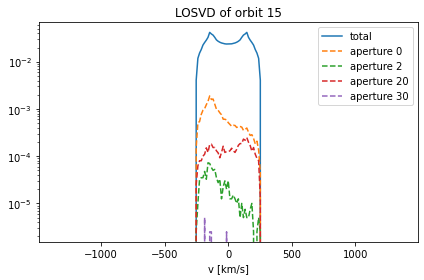

In [32]:
orb_idx = 15
aperture_idx_list = [0, 2, 20, 30]
plot_losvds(model.orblib.losvd_histograms, orb_idx, aperture_idx_list)

In some apertures, this orbit hardly contributes at all. One of these orbits looks interesting - the one in aperture 20. Let's plot this one on its own,

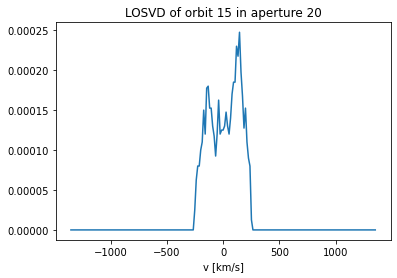

In [34]:
orb_idx, aperture_idx = 15, 20
v_arr = model.orblib.losvd_histograms.x
losvd = model.orblib.losvd_histograms.y[orb_idx, :, aperture_idx]

plt.plot(v_arr, losvd)
plt.gca().set_xlabel('v [km/s]')
title = f'LOSVD of orbit {orb_idx} in aperture {aperture_idx}'
_ = plt.gca().set_title(title)

It's bimodal!

In order to compare the orbits we have calculated to the observations, we must transform the kinematics of the orbit to the same type as the observations. As described above, the only type of observed kinematics that we currently support are Gauss Hermite kinematics. Let's see how Gauss Hermite kinematics do at reproducing the bimodal LOSVD above.

The function to do the transoformation from orbits to observed kinematics is held in the kinematcs object itself, so lets extract this,

In [35]:
kinematics = c.system.cmp_list[2].kinematic_data[0]

and lets extract the observed $v$ and sigma in the aperture of interest,

In [36]:
row_idx = np.where(kinematics.data['vbin_id']==aperture_idx)[0][0]
v, sigma = kinematics.data[row_idx]['v', 'sigma']
print(f'In aperture {aperture_idx}:')
print(f'   v = {v} km/s')
print(f'   sigma = {sigma} km/s')

In aperture 20:
   v = -16.4615 km/s
   sigma = 143.857 km/s


Now let's fit a Gauss Hermite distirbution to the orbit's LOSVD. When we solved for the orbital weights earlier, this was all done "under-the-hood". Now let's see it in action,

In [37]:
velhist = dyn.kinematics.Histogram(
    xedg=model.orblib.losvd_histograms.xedg,
    y=losvd)

gh_coefficients = kinematics.get_gh_expansion_coefficients(
    v_mu=v,
    v_sig=sigma,
    vel_hist=velhist,
    max_order=4)

tmp = np.squeeze(gh_coefficients) # removes unused empty dimensions
print('GH coefficient:')
for i, hi in enumerate(tmp):
    print(f'   h_{i} = {hi}')

GH coefficient:
   h_0 = 0.9589395643473766
   h_1 = 0.17675160662762332
   h_2 = 0.2035668065225786
   h_3 = 0.022320870590947103
   h_4 = -0.2648117749784247


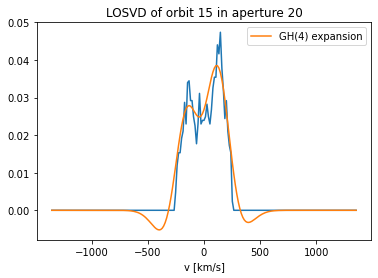

In [38]:
gh_losvd = kinematics.evaluate_losvd(velhist.x,
                                     np.array([v]),
                                     np.array([sigma]),
                                     gh_coefficients)
gh_losvd = np.squeeze(gh_losvd)

# normalise the two LOSVDs so that we can plot them on the same axis
losvd /= np.sum(losvd) 
gh_losvd /= np.sum(gh_losvd)

# plot
plt.plot(v_arr, losvd)
plt.plot(v_arr, gh_losvd, label='GH(4) expansion')
plt.gca().legend()
plt.gca().set_xlabel('v [km/s]')
title = f'LOSVD of orbit {orb_idx} in aperture {aperture_idx}'
_ = plt.gca().set_title(title)

The Gauss Hermite parameterisaion of the LOSVD does an OK job at reproducing the bimodality of the LOSVD, although the peaks are somewhat underpredicted. The cost of this, however, are significant, unphysical negative wings!

This isn't good! The LOSVD should not become negative. The fact that is does could bias our modelling. This is one of our key motivations for wanting to replace Gauss Hermites with different parametresiations of the LOSVD.

## Looking at the oribtal weights

Let's look at the best fitting orbital weights,

In [39]:
model.weight_solver.read_weights()
model.weight_solver.weights

orb_idx,E_idx,I2_idx,I3_idx,orb_type,weight,lcut
int64,int64,int64,int64,int64,float64,int64
1,1,1,1,3,0.000602178,-1
2,1,-1,1,3,0.0,-1
3,1,1,2,3,0.0,-1
4,1,-1,2,3,0.0,-1
5,1,1,3,3,0.0,-1
6,1,-1,3,3,0.0,-1
7,1,2,1,3,0.0,-1
8,1,-2,1,3,0.0,-1
9,1,2,2,3,0.0,-1


There is a row for every orbit, a weight for every orbit.

What does the LOSVD look like for this set of weights? Again, if we just stick to the same aperture we were looking at earlier, then 

For this set of weights (found buy the NNL optimization routine) let's look at the model LOSVD that we produce, again in the same aperture we were looking at above, and compare it to the observed LOSVD there

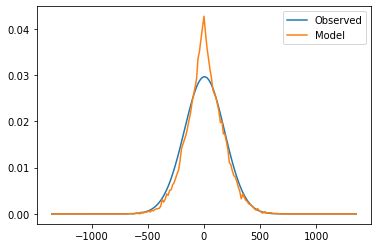

In [52]:
# extract the model LOSVD for the orbital weights above
w = model.weight_solver.weights['weight']
orbit_losvds = model.orblib.losvd_histograms.y

model_losvd = np.dot(orbit_losvds.T, w).T
model_losvd /= np.sum(model_losvd, 0)

# extract the observed LOSVD
v, sigma, h3, h4 = kinematics.data[aperture_idx]['v', 'sigma', 'h3', 'h4']
h0, h1, h2 = 1., 0., 0.
gh_coefficients = np.array([[[h0, h1, h2, h3, h4]]])

gh_losvd_obs = kinematics.evaluate_losvd(velhist.x,
                                     np.array([v]),
                                     np.array([sigma]),
                                     gh_coefficients)
gh_losvd_obs = np.squeeze(gh_losvd_obs)
gh_losvd_obs /= np.sum(gh_losvd_obs)
gh_losvd_obs = np.squeeze(gh_losvd_obs)

# plot them
plt.plot(v_arr, np.squeeze(gh_losvd), label='Observed')
plt.plot(v_arr, model_losvd[:, aperture_idx], label='Model')
plt.gca().legend()

The width is good! But what about the sharp peak!? What's that!?

The 'model' LOSVD we plotted above is the weighted sum of the histogrammed orbit LOSVDS. But, the comparisaon against observations was done with Gauss Hermite expansions, not histograms. Let look at what the model distributions with Gauss Hermites would look like,

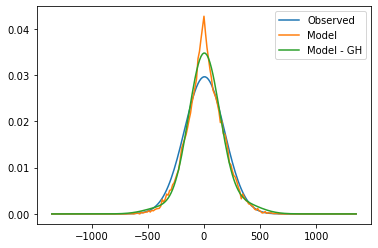

In [53]:
tmp = model.orblib.losvd_histograms.y[:,:,aperture_idx]
vel_hist = dyn.kinematics.Histogram(
    xedg=model.orblib.losvd_histograms.xedg,
    y=tmp,
    normalise=False)

gh_coefficients = kinematics.get_gh_expansion_coefficients(
    v_mu=kinematics.data['v'][aperture_idx],
    v_sig=kinematics.data['sigma'][aperture_idx],
    vel_hist=vel_hist,
    max_order=4)

gh_orb_losvd = kinematics.evaluate_losvd(
    velhist.x,
    kinematics.data['v'][[aperture_idx]],
    kinematics.data['sigma'][[aperture_idx]],
    gh_coefficients)
gh_orb_losvd = np.squeeze(gh_orb_losvd)
gh_orb_losvd = np.dot(gh_orb_losvd.T, w).T
gh_orb_losvd /= np.sum(gh_orb_losvd)

# plot them
plt.plot(v_arr, np.squeeze(gh_losvd), label='Observed')
plt.plot(v_arr, model_losvd[:, aperture_idx], label='Model')
plt.plot(v_arr, gh_orb_losvd, label='Model - GH')
plt.gca().legend()

By construciton, the GH representation of the model is a better match to the observations. But the fact that the GH representation of the model is visibly different from the model constructed from histograms is again a sign that the GH expansion is not ideal.

## Exercises

Stuff to try out:
- change the number of Gauss Hermite coeffients used: does the problem go away?
- can you find other LOSVDs problematic for the GH expansion?
- what is the total weight of orbits which go through aperture 0?
- what is the total weight of orbits which have negative velocity in apeture 0?
- plot the observed/model/model-GH LOSVDs of the whole galaxy (i.e. combine all apertures together)
- run another model with a larger orbit library
- run another model with a larger orbit library